RF-default: 0.730 (0.045)
CART-default: 0.686 (0.041)
NB-default: 0.553 (0.048)
NB-std: 0.553 (0.048)
NB-norm: 0.553 (0.048)
KNN-def: 0.568 (0.054)
KNN-std: 0.581 (0.064)
KNN-norm: 0.566 (0.052)
SVM-def: 0.665 (0.101)
SVM-std: 0.656 (0.108)
SVM-norm: 0.667 (0.099)


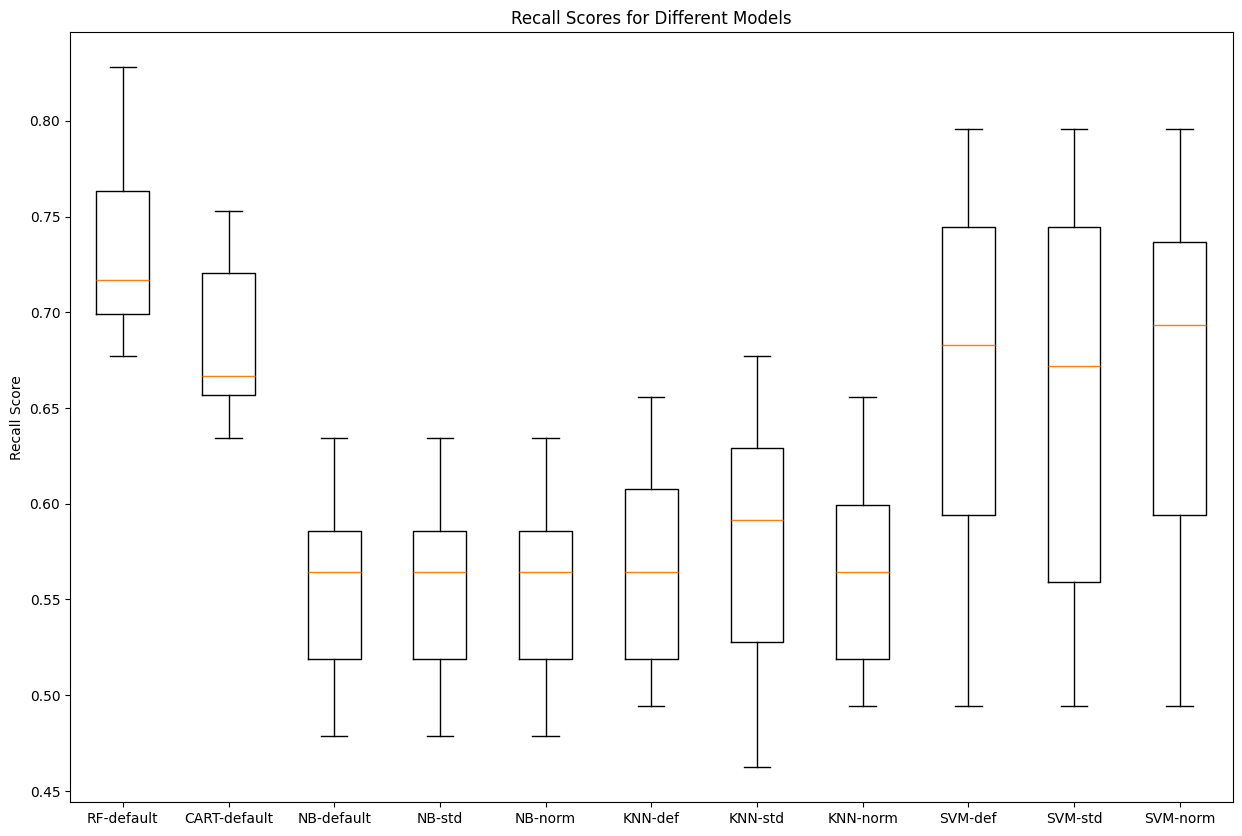

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings("ignore")

dataset = pd.read_csv('../data/samu_cases_ready.csv')

test_size = 0.2
seed = 42


# why recall?
# We need to reduce the deaths before medical care
# Recall focus on predict the most of cases that are deaths, even if we have some false positives
scoring = 'recall'

X = dataset.drop(columns=['outcome'], axis=1)
y = dataset['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)


undersampler = RandomUnderSampler(sampling_strategy='majority')
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Why reduce the dimensionality with PCA?
# We have more then 10 features
# In medical care context we have a lot of features that are correlated and could be selected between them depending on the agent from SAMU
# At previous tests, some algorithms were overfitting (SVM)
pca = ('pca', PCA(n_components=2, random_state=seed))

y_train = y_train.astype(int)
y_test = y_test.astype(int)

categorical_features = ['subtype', 'type']
numerical_features = ['RPA', 'age', 'gender']


encoder = ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
standard_scaler = ('std', StandardScaler())
min_max_scaler = ('norm', MinMaxScaler())

pipelines = []


RF = ('RF', RandomForestClassifier(random_state=seed))
NB = ('NB', GaussianNB())
KNN = ('KNN', KNeighborsClassifier())
CART = ('CART', DecisionTreeClassifier(random_state=seed))
SVM = ('SVM', SVC(random_state=seed))

# RF pipeline
# Random Forest has a better performance with default values only
# only encoder needed
pipelines.append(('RF-default', Pipeline([encoder, RF]))) 

# CART pipeline
# Decision Tree has a better performance with default values only
# only encoder needed
pipelines.append(('CART-default', Pipeline([encoder, CART])))

# NB pipeline
pipelines.append(('NB-default', Pipeline([encoder, pca, NB])))
pipelines.append(('NB-std', Pipeline([encoder, pca, standard_scaler, NB])))
pipelines.append(('NB-norm', Pipeline([encoder, pca, min_max_scaler, NB])))

# KNN pipeline
pipelines.append(('KNN-def', Pipeline([encoder, pca, KNN])))
pipelines.append(('KNN-std', Pipeline([encoder, pca, standard_scaler, KNN])))
pipelines.append(('KNN-norm', Pipeline([encoder, pca, min_max_scaler, KNN])))


# SVM pipeline
pipelines.append(('SVM-def', Pipeline([encoder, pca, SVM])))
pipelines.append(('SVM-std', Pipeline([encoder, pca, standard_scaler, SVM])))
pipelines.append(('SVM-norm', Pipeline([encoder, pca, min_max_scaler, SVM])))


n_folds = 10
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

scores = []
names = []


for name, model in pipelines:
    names.append(name)
    score = cross_val_score(model, X_train_resampled, y_train_resampled, cv=kfold, scoring=scoring)
    scores.append(score)
    msg = "%s: %.3f (%.3f)" % (name, score.mean(), score.std())
    print(msg)


plt.figure(figsize=(15,10))
plt.boxplot(scores)
plt.title('Recall Scores for Different Models')
plt.ylabel('Recall Score')
plt.xticks(range(1, len(names)+1), names)
plt.show()



### Tunning Random Forest Classifier

In [2]:
np.random.seed(42)

encoder = ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())
pca = ('pca', PCA(n_components=2))

pipelines = []
results = []
names = []


RF = ('RF', RandomForestClassifier())
RF_param_grid = {
    'RF__n_estimators': [10, 50, 100],
    'RF__max_features': ['auto', 'sqrt', 'log2'],
    'RF__max_depth': [None, 10, 20, 30],
    'RF__min_samples_split': [2, 5, 10],
    'RF__min_samples_leaf': [1, 2, 4]
}

pipelines.append(('RF-default', Pipeline(steps=[encoder, pca, RF])))


print('🔎 Starting analysis for model with grid search')
print('Grab a ☕️, this should take a while... ⏳')

for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=RF_param_grid, cv=kfold, scoring='recall')
    grid_result = grid.fit(X_train_resampled, y_train_resampled)
    best_params = {k: float(v) if isinstance(v, np.float64) else v for k, v in grid_result.best_params_.items()}
    results.append(grid_result.best_score_)
    names.append(name)
    print("%s - Better %f with %s" % (name, grid_result.best_score_, best_params))
    
# it takes about 7min

🔎 Starting analysis for model with grid search
Grab a ☕️, this should take a while... ⏳
RF-default - Better 0.717536 with {'RF__max_depth': None, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2, 'RF__n_estimators': 10}


### RF with default params  > RF with GridSearch score 

#### Testing with unseen data from model

In [3]:
np.random.seed(42)

encoder = ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
model = ('RF', RandomForestClassifier())

pipeline = Pipeline(steps=[encoder, model])

pipeline.fit(X_train_resampled, y_train_resampled)
prediction = pipeline.predict(X_test)
print(name, 'Recall:', recall_score(y_test, prediction))


RF-default Recall: 0.7428571428571429


##### Simulating new data to predict:

In [4]:
pipeline.fit(X, y)

new_data = pd.DataFrame({
    'timestamp': ['morning'],
    'type': ['RESPIRATORIA'],
    'subtype': ['DISPNEIA'],
    'gender': [1],
    'age': [1],
})

prediction = pipeline.predict(new_data)
print(prediction)

[0]


## Exporting model with pipeline 

In [8]:
import pickle

pipeline.fit(X, y)

pipeline_filename = 'model_pipeline.pkl'
with open('../models/' + pipeline_filename, 'wb') as file:
    pickle.dump(pipeline, file)


## Data Insights 💡 🤯

In [ ]:
# TODO:
## deaths x time x gender x type x age